# Working Up to a Searchlight

### note that for right now I'm doing search light in anatomical parcels similar to our rois - not full ventral masks

In [1]:
# Cell 1: Setup and verify data for one subject
import numpy as np
import pandas as pd
from pathlib import Path
import nibabel as nib

# Paths
BASE_DIR = Path('/user_data/csimmon2/long_pt')
subject = 'sub-004'
session = '01'
sub_num = subject.replace('sub-', '')  # '004'

# Directories
func_base = BASE_DIR / subject / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc'
cov_dir = BASE_DIR / subject / f'ses-{session}' / 'covs'
roi_dir = BASE_DIR / subject / f'ses-{session}' / 'ROIs'

# Find available runs
runs = sorted([d.name for d in func_base.glob('run-*') if d.is_dir()])
print(f"Available runs: {runs}")

# Verify functional data
for run in runs:
    func_file = func_base / run / '1stLevel.feat' / 'filtered_func_data_reg.nii.gz'
    print(f"  {run}: {func_file.exists()}")

# Verify timing files (run-01)
print("\nTiming files (run-01):")
for cat in ['Face', 'Word', 'Object', 'House', 'Scramble']:
    timing_file = cov_dir / f'catloc_{sub_num}_run-01_{cat}.txt'
    print(f"  {cat}: {timing_file.exists()}")

# Verify search masks
print("\nSearch masks:")
for hemi in ['l', 'r']:
    for cat in ['face', 'word', 'object', 'house']:
        mask_file = roi_dir / f'{hemi}_{cat}_searchmask.nii.gz'
        print(f"  {hemi}_{cat}: {mask_file.exists()}")

Available runs: ['run-01', 'run-02', 'run-03', 'run-04']
  run-01: True
  run-02: True
  run-03: True
  run-04: False

Timing files (run-01):
  Face: True
  Word: True
  Object: True
  House: True
  Scramble: True

Search masks:
  l_face: True
  l_word: True
  l_object: True
  l_house: True
  r_face: False
  r_word: False
  r_object: False
  r_house: False


In [2]:
# Cell 2: Extract block patterns for one run
TR = 2.0
HRF_DELAY = 4  # seconds

# Load functional data
func_file = func_base / 'run-01' / '1stLevel.feat' / 'filtered_func_data_reg.nii.gz'
func_img = nib.load(func_file)
func_data = func_img.get_fdata()
affine = func_img.affine
print(f"Functional shape: {func_data.shape}")  # (x, y, z, time)

# Load timing for Face
timing_file = cov_dir / f'catloc_{sub_num}_run-01_Face.txt'
timing = np.loadtxt(timing_file)
print(f"Timing: {timing.shape[0]} blocks, {timing[0,1]}s duration")

# Extract block patterns
def extract_blocks(func_data, timing, tr=2.0, hrf_delay=4):
    """Extract mean pattern for each block"""
    patterns = []
    for onset, duration, _ in timing:
        start_vol = int((onset + hrf_delay) / tr)
        end_vol = int((onset + duration + hrf_delay) / tr)
        end_vol = min(end_vol, func_data.shape[-1])
        
        block_mean = np.mean(func_data[..., start_vol:end_vol], axis=-1)
        patterns.append(block_mean)
    return np.array(patterns)

face_patterns = extract_blocks(func_data, timing)
print(f"Face patterns shape: {face_patterns.shape}")  # (3, x, y, z)

Functional shape: (176, 256, 256, 184)
Timing: 3 blocks, 16.0s duration
Face patterns shape: (3, 176, 256, 256)


In [3]:
# Cell 3: Extract patterns for Face vs Scramble, apply mask
categories = ['Face', 'Scramble']

# Load search mask
mask_file = roi_dir / 'l_face_searchmask.nii.gz'
mask_img = nib.load(mask_file)
mask_data = mask_img.get_fdata() > 0
print(f"Mask voxels: {np.sum(mask_data)}")

# Extract patterns for all runs
all_patterns = []
all_labels = []
all_runs = []

for run in ['run-01', 'run-02', 'run-03']:
    func_file = func_base / run / '1stLevel.feat' / 'filtered_func_data_reg.nii.gz'
    func_data = nib.load(func_file).get_fdata()
    
    run_num = int(run.split('-')[1])
    
    for cat_idx, cat in enumerate(categories):
        timing_file = cov_dir / f'catloc_{sub_num}_{run}_{cat}.txt'
        timing = np.loadtxt(timing_file)
        
        patterns = extract_blocks(func_data, timing)
        
        for p in patterns:
            all_patterns.append(p)
            all_labels.append(cat_idx)  # 0=Face, 1=Scramble
            all_runs.append(run_num)

X = np.array(all_patterns)
y = np.array(all_labels)
runs = np.array(all_runs)

print(f"X shape: {X.shape}")  # (n_samples, x, y, z)
print(f"Labels: {np.bincount(y)} (Face, Scramble)")
print(f"Runs: {np.bincount(runs)[1:]}")  # blocks per run

Mask voxels: 19331
X shape: (18, 176, 256, 256)
Labels: [9 9] (Face, Scramble)
Runs: [6 6 6]


In [ ]:
# Cell 4: Searchlight setup
from nilearn.decoding import SearchLight
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut

# Apply mask to restrict searchlight
from nilearn.image import new_img_like

# Create 4D image from patterns
X_img = new_img_like(mask_img, np.transpose(X, (1, 2, 3, 0)))

# Classifier and CV
clf = SVC(kernel='linear')
cv = LeaveOneGroupOut()

# Searchlight
sl = SearchLight(
    mask_img=mask_img,
    radius=6,  # mm
    estimator=clf,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

print(f"Ready to fit searchlight")
print(f"  Samples: {len(y)}")
print(f"  CV folds: {len(np.unique(runs))}")

/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


Ready to fit searchlight
  Samples: 18
  CV folds: 3


In [14]:
# Cell 4c: Test on subset of mask
from scipy.ndimage import binary_erosion

# Erode mask to get smaller test region
test_mask = binary_erosion(mask_data, iterations=2)
print(f"Original voxels: {np.sum(mask_data)}")
print(f"Test voxels: {np.sum(test_mask)}")

#test_mask_img = new_img_like(mask_img, test_mask.astype(float))

Original voxels: 19331
Test voxels: 7543


In [ ]:
# Cell 4d: BrainIAK searchlight
from brainiak.searchlight.searchlight import Searchlight, Ball
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut

# Reshape data for brainiak: (x, y, z, samples)
data_4d = np.transpose(X, (1, 2, 3, 0))

def svm_cv(data, sl_mask, myrad, bcvar):
    """Classification at each searchlight"""
    y, groups = bcvar
    bold = data[0].reshape(-1, data[0].shape[-1]).T  # (samples, voxels)
    
    if bold.shape[1] < 5:
        return 0.5
    
    clf = SVC(kernel='linear')
    cv = LeaveOneGroupOut()
    scores = cross_val_score(clf, bold, y, cv=cv, groups=groups)
    return np.mean(scores)

sl = Searchlight(sl_rad=6, max_blk_edge=5, shape=Ball)
sl.distribute([data_4d], mask_data.astype(int))
sl.broadcast((y, runs))
   
print("Running BrainIAK searchlight...")
results = sl.run_searchlight(svm_cv, pool_size=1)
print("Done")

Running BrainIAK searchlight...
Done


Map shape: (176, 256, 256)
Max accuracy: 1.00


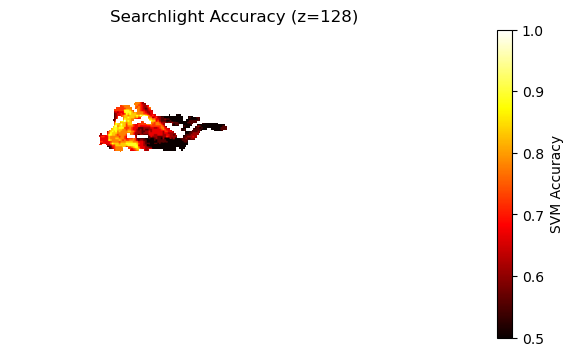

In [9]:
# 1. 'results' is ALREADY the 3D map, but likely holds 'None' for outside voxels
# We convert it to a float array, which turns 'None' -> 'NaN' automatically
accuracy_map = np.array(results, dtype=float)

# 2. Check the shape (It should match your original data dimensions, e.g., 64x64x30)
print(f"Map shape: {accuracy_map.shape}")
print(f"Max accuracy: {np.nanmax(accuracy_map):.2f}")

# 3. Visualize it
import matplotlib.pyplot as plt

# Pick a middle slice (change '30' to a valid z-slice for your brain)
z_slice = accuracy_map.shape[2] // 2 

plt.figure(figsize=(10, 4))
# 'hot' cmap makes high accuracy red/yellow, low accuracy black
plt.imshow(accuracy_map[:, :, z_slice], cmap='hot', vmin=0.5, vmax=1.0)
plt.colorbar(label='SVM Accuracy')
plt.title(f'Searchlight Accuracy (z={z_slice})')
plt.axis('off')
plt.show()

In [12]:
# Cell 6: Run searchlight for all categories, both sessions
from brainiak.searchlight.searchlight import Searchlight, Ball
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
from sklearn.svm import SVC

categories = ['Face', 'Object', 'House', 'Word']
sessions = ['01', '02']
hemi = 'l'  # sub-004 only has left hemisphere masks

results_all = {}

def svm_cv(data, sl_mask, myrad, bcvar):
    y, groups = bcvar
    bold = data[0].reshape(-1, data[0].shape[-1]).T
    if bold.shape[1] < 5:
        return 0.5
    clf = SVC(kernel='linear')
    cv = LeaveOneGroupOut()
    scores = cross_val_score(clf, bold, y, cv=cv, groups=groups)
    return np.mean(scores)

for cat in categories:
    cat_lower = cat.lower()
    results_all[cat] = {}
    
    for ses in sessions:
        print(f"\n=== {cat} Session {ses} ===")
        
        # Paths
        ses_dir = BASE_DIR / subject / f'ses-{ses}'
        func_base = ses_dir / 'derivatives' / 'fsl' / 'loc'
        cov_dir = ses_dir / 'covs'
        roi_dir = BASE_DIR / subject / 'ses-01' / 'ROIs'  # masks from ses-01
        
        # Load mask
        mask_file = roi_dir / f'{hemi}_{cat_lower}_searchmask.nii.gz'
        if not mask_file.exists():
            print(f"  Mask not found: {mask_file}")
            continue
        mask_img = nib.load(mask_file)
        mask_data = mask_img.get_fdata() > 0
        print(f"  Mask voxels: {np.sum(mask_data)}")
        
        # Find runs
        runs_available = sorted([d.name for d in func_base.glob('run-*') if d.is_dir()])
        runs_available = [r for r in runs_available if (func_base / r / '1stLevel.feat' / 'filtered_func_data_reg.nii.gz').exists()]
        print(f"  Runs: {runs_available}")
        
        # Extract patterns
        all_patterns = []
        all_labels = []
        all_runs = []
        
        for run in runs_available:
            func_file = func_base / run / '1stLevel.feat' / 'filtered_func_data_reg.nii.gz'
            func_data = nib.load(func_file).get_fdata()
            run_num = int(run.split('-')[1])
            
            for cat_idx, c in enumerate([cat, 'Scramble']):
                timing_file = cov_dir / f'catloc_{sub_num}_{run}_{c}.txt'
                if not timing_file.exists():
                    print(f"  Missing timing: {timing_file.name}")
                    continue
                timing = np.loadtxt(timing_file)
                patterns = extract_blocks(func_data, timing)
                
                for p in patterns:
                    all_patterns.append(p)
                    all_labels.append(cat_idx)
                    all_runs.append(run_num)
        
        X = np.array(all_patterns)
        y = np.array(all_labels)
        runs_arr = np.array(all_runs)
        print(f"  Samples: {len(y)} ({np.sum(y==0)} {cat}, {np.sum(y==1)} Scramble)")
        
        # Run searchlight
        data_4d = np.transpose(X, (1, 2, 3, 0))
        sl = Searchlight(sl_rad=6, max_blk_edge=5, shape=Ball)
        sl.distribute([data_4d], mask_data.astype(int))
        sl.broadcast((y, runs_arr))
        
        acc_map = sl.run_searchlight(svm_cv, pool_size=1)
        acc_map = np.array(acc_map, dtype=float)
        
        results_all[cat][ses] = {
            'accuracy_map': acc_map,
            'mean_acc': np.nanmean(acc_map[mask_data]),
            'max_acc': np.nanmax(acc_map)
        }
        print(f"  Mean accuracy: {results_all[cat][ses]['mean_acc']:.3f}")

print("\n=== DONE ===")


=== Face Session 01 ===
  Mask voxels: 19331
  Runs: ['run-01', 'run-02', 'run-03']
  Samples: 18 (9 Face, 9 Scramble)
  Mean accuracy: 0.580

=== Face Session 02 ===
  Mask voxels: 19331
  Runs: ['run-01', 'run-02', 'run-03']
  Samples: 18 (9 Face, 9 Scramble)
  Mean accuracy: 0.539

=== Object Session 01 ===
  Mask voxels: 25843
  Runs: ['run-01', 'run-02', 'run-03']
  Samples: 18 (9 Object, 9 Scramble)
  Mean accuracy: 0.568

=== Object Session 02 ===
  Mask voxels: 25843
  Runs: ['run-01', 'run-02', 'run-03']
  Samples: 18 (9 Object, 9 Scramble)
  Mean accuracy: 0.673

=== House Session 01 ===
  Mask voxels: 24507
  Runs: ['run-01', 'run-02', 'run-03']
  Samples: 18 (9 House, 9 Scramble)
  Mean accuracy: 0.452

=== House Session 02 ===
  Mask voxels: 24507
  Runs: ['run-01', 'run-02', 'run-03']
  Samples: 18 (9 House, 9 Scramble)
  Mean accuracy: 0.492

=== Word Session 01 ===
  Mask voxels: 19331
  Runs: ['run-01', 'run-02', 'run-03']
  Samples: 18 (9 Word, 9 Scramble)
  Mean acc

In [13]:
# Cell 6: Run searchlight for all categories, both sessions
from brainiak.searchlight.searchlight import Searchlight, Ball
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
from sklearn.svm import SVC

categories = ['Face', 'Object', 'House', 'Word']
sessions = ['01', '02']
hemi = 'l'  # sub-004 only has left hemisphere masks

results_all = {}

def svm_cv(data, sl_mask, myrad, bcvar):
    y, groups = bcvar
    bold = data[0].reshape(-1, data[0].shape[-1]).T
    if bold.shape[1] < 5:
        return 0.5
    clf = SVC(kernel='linear')
    cv = LeaveOneGroupOut()
    scores = cross_val_score(clf, bold, y, cv=cv, groups=groups)
    return np.mean(scores)

for cat in categories:
    cat_lower = cat.lower()
    results_all[cat] = {}
    
    for ses in sessions:
        print(f"\n=== {cat} Session {ses} ===")
        
        # Paths
        ses_dir = BASE_DIR / subject / f'ses-{ses}'
        func_base = ses_dir / 'derivatives' / 'fsl' / 'loc'
        cov_dir = ses_dir / 'covs'
        roi_dir = BASE_DIR / subject / 'ses-01' / 'ROIs'  # masks from ses-01
        
        # Load mask
        mask_file = roi_dir / f'{hemi}_{cat_lower}_searchmask.nii.gz'
        if not mask_file.exists():
            print(f"  Mask not found: {mask_file}")
            continue
        mask_img = nib.load(mask_file)
        mask_data = mask_img.get_fdata() > 0
        print(f"  Mask voxels: {np.sum(mask_data)}")
        
        # Find runs
        runs_available = sorted([d.name for d in func_base.glob('run-*') if d.is_dir()])
        runs_available = [r for r in runs_available if (func_base / r / '1stLevel.feat' / 'filtered_func_data_reg.nii.gz').exists()]
        print(f"  Runs: {runs_available}")
        
        # Extract patterns
        all_patterns = []
        all_labels = []
        all_runs = []
        
        for run in runs_available:
            func_file = func_base / run / '1stLevel.feat' / 'filtered_func_data_reg.nii.gz'
            func_data = nib.load(func_file).get_fdata()
            run_num = int(run.split('-')[1])
            
            for cat_idx, c in enumerate([cat, 'Scramble']):
                timing_file = cov_dir / f'catloc_{sub_num}_{run}_{c}.txt'
                if not timing_file.exists():
                    print(f"  Missing timing: {timing_file.name}")
                    continue
                timing = np.loadtxt(timing_file)
                patterns = extract_blocks(func_data, timing)
                
                for p in patterns:
                    all_patterns.append(p)
                    all_labels.append(cat_idx)
                    all_runs.append(run_num)
        
        X = np.array(all_patterns)
        y = np.array(all_labels)
        runs_arr = np.array(all_runs)
        print(f"  Samples: {len(y)} ({np.sum(y==0)} {cat}, {np.sum(y==1)} Scramble)")
        
        # Run searchlight
        data_4d = np.transpose(X, (1, 2, 3, 0))
        sl = Searchlight(sl_rad=6, max_blk_edge=5, shape=Ball)
        sl.distribute([data_4d], mask_data.astype(int))
        sl.broadcast((y, runs_arr))
        
        acc_map = sl.run_searchlight(svm_cv, pool_size=1)
        acc_map = np.array(acc_map, dtype=float)
        
        results_all[cat][ses] = {
            'accuracy_map': acc_map,
            'mean_acc': np.nanmean(acc_map[mask_data]),
            'max_acc': np.nanmax(acc_map)
        }
        print(f"  Mean accuracy: {results_all[cat][ses]['mean_acc']:.3f}")

print("\n=== DONE ===")


=== Face Session 01 ===
  Mask voxels: 19331
  Runs: ['run-01', 'run-02', 'run-03']
  Samples: 18 (9 Face, 9 Scramble)
  Mean accuracy: 0.580

=== Face Session 02 ===
  Mask voxels: 19331
  Runs: ['run-01', 'run-02', 'run-03']
  Samples: 18 (9 Face, 9 Scramble)
  Mean accuracy: 0.539

=== Object Session 01 ===
  Mask voxels: 25843
  Runs: ['run-01', 'run-02', 'run-03']
  Samples: 18 (9 Object, 9 Scramble)
  Mean accuracy: 0.568

=== Object Session 02 ===
  Mask voxels: 25843
  Runs: ['run-01', 'run-02', 'run-03']
  Samples: 18 (9 Object, 9 Scramble)
  Mean accuracy: 0.673

=== House Session 01 ===
  Mask voxels: 24507
  Runs: ['run-01', 'run-02', 'run-03']
  Samples: 18 (9 House, 9 Scramble)
  Mean accuracy: 0.452

=== House Session 02 ===
  Mask voxels: 24507
  Runs: ['run-01', 'run-02', 'run-03']
  Samples: 18 (9 House, 9 Scramble)
  Mean accuracy: 0.492

=== Word Session 01 ===
  Mask voxels: 19331
  Runs: ['run-01', 'run-02', 'run-03']
  Samples: 18 (9 Word, 9 Scramble)
  Mean acc

In [14]:
# Cell 7: Compute session comparisons
from scipy.ndimage import binary_dilation

def compute_dice(map1, map2, mask, threshold=0.55):
    """Dice coefficient between thresholded accuracy maps"""
    bin1 = (map1 > threshold) & mask
    bin2 = (map2 > threshold) & mask
    intersection = np.sum(bin1 & bin2)
    total = np.sum(bin1) + np.sum(bin2)
    return 2 * intersection / total if total > 0 else 0

# Summary
print("Category        | Ses-01 | Ses-02 | Change | Dice(0.55)")
print("-" * 55)

for cat in categories:
    if '01' in results_all[cat] and '02' in results_all[cat]:
        acc1 = results_all[cat]['01']['mean_acc']
        acc2 = results_all[cat]['02']['mean_acc']
        change = acc2 - acc1
        
        # Load mask for Dice
        mask_file = BASE_DIR / subject / 'ses-01' / 'ROIs' / f'{hemi}_{cat.lower()}_searchmask.nii.gz'
        mask_data = nib.load(mask_file).get_fdata() > 0
        
        dice = compute_dice(
            results_all[cat]['01']['accuracy_map'],
            results_all[cat]['02']['accuracy_map'],
            mask_data
        )
        
        cat_type = "Uni" if cat in ['Face', 'Word'] else "Bil"
        print(f"{cat:15} | {acc1:.3f}  | {acc2:.3f}  | {change:+.3f}  | {dice:.3f}  [{cat_type}]")

Category        | Ses-01 | Ses-02 | Change | Dice(0.55)
-------------------------------------------------------
Face            | 0.580  | 0.539  | -0.041  | 0.587  [Uni]
Object          | 0.568  | 0.673  | +0.106  | 0.752  [Bil]
House           | 0.452  | 0.492  | +0.040  | 0.245  [Bil]
Word            | 0.581  | 0.528  | -0.053  | 0.529  [Uni]


In [22]:
# Cell 8: Cross-temporal searchlight for all categories
from sklearn.preprocessing import StandardScaler

def svm_cross_temporal(data, sl_mask, myrad, bcvar):
    y1, y2 = bcvar
    bold1 = data[0].reshape(-1, data[0].shape[-1]).T
    bold2 = data[1].reshape(-1, data[1].shape[-1]).T
    
    if bold1.shape[1] < 5:
        return 0.5
    
    scaler = StandardScaler()
    bold1_scaled = scaler.fit_transform(bold1)
    bold2_scaled = scaler.transform(bold2)
    
    clf = SVC(kernel='linear')
    clf.fit(bold1_scaled, y1)
    return clf.score(bold2_scaled, y2)

cross_temporal_results = {}

for cat in categories:
    print(f"\n=== {cat} ===")
    X1, y1 = extract_session_patterns('01', cat)
    X2, y2 = extract_session_patterns('02', cat)
    
    mask_file = BASE_DIR / subject / 'ses-01' / 'ROIs' / f'l_{cat.lower()}_searchmask.nii.gz'
    mask_data = nib.load(mask_file).get_fdata() > 0
    
    data1_4d = np.transpose(X1, (1, 2, 3, 0))
    data2_4d = np.transpose(X2, (1, 2, 3, 0))
    
    sl = Searchlight(sl_rad=6, max_blk_edge=5, shape=Ball)
    sl.distribute([data1_4d, data2_4d], mask_data.astype(int))
    sl.broadcast((y1, y2))
    
    ct_map = np.array(sl.run_searchlight(svm_cross_temporal, pool_size=1), dtype=float)
    mean_acc = np.nanmean(ct_map[mask_data])
    
    cross_temporal_results[cat] = {'map': ct_map, 'mean': mean_acc}
    print(f"Cross-temporal accuracy: {mean_acc:.3f}")

# Summary
print("\n" + "="*50)
print("Category        | Cross-Temp | Within-Ses Avg | Diff")
print("-"*50)
for cat in categories:
    ct = cross_temporal_results[cat]['mean']
    within = (results_all[cat]['01']['mean_acc'] + results_all[cat]['02']['mean_acc']) / 2
    cat_type = "Uni" if cat in ['Face', 'Word'] else "Bil"
    print(f"{cat:15} | {ct:.3f}      | {within:.3f}          | {ct-within:+.3f} [{cat_type}]")


=== Face ===
Cross-temporal accuracy: 0.498

=== Object ===
Cross-temporal accuracy: 0.503

=== House ===
Cross-temporal accuracy: 0.501

=== Word ===
Cross-temporal accuracy: 0.499

Category        | Cross-Temp | Within-Ses Avg | Diff
--------------------------------------------------
Face            | 0.498      | 0.560          | -0.061 [Uni]
Object          | 0.503      | 0.621          | -0.118 [Bil]
House           | 0.501      | 0.472          | +0.029 [Bil]
Word            | 0.499      | 0.554          | -0.055 [Uni]


In [27]:
# Cell 9: Apply ses-01 peak classifier across ses-02 (fixed)
results_transfer = {}

for cat in categories:
    X1, y1 = extract_session_patterns('01', cat)
    X2, y2 = extract_session_patterns('02', cat)
    
    mask_file = BASE_DIR / subject / 'ses-01' / 'ROIs' / f'l_{cat.lower()}_searchmask.nii.gz'
    mask_data = nib.load(mask_file).get_fdata() > 0
    
    # Ses-01 peak
    acc1 = results_all[cat]['01']['accuracy_map'].copy()
    acc1[~mask_data] = np.nan
    peak1 = np.unravel_index(np.nanargmax(acc1), acc1.shape)
    
    # Train at ses-01 peak
    peak1_voxels = get_sphere_voxels(peak1, mask_data)
    n_vox = len(peak1_voxels)
    X1_peak = np.array([X1[i][tuple(peak1_voxels.T)] for i in range(len(X1))])
    scaler = StandardScaler()
    clf = SVC(kernel='linear')
    clf.fit(scaler.fit_transform(X1_peak), y1)
    
    # Test across ses-02 with tolerance
    mask_coords = np.array(np.where(mask_data)).T
    ses2_accuracy = np.full(mask_data.shape, np.nan)
    tested = 0
    
    for coord in mask_coords:
        voxels = get_sphere_voxels(tuple(coord), mask_data)
        if len(voxels) < n_vox * 0.8:  # 80% tolerance
            continue
        # Pad or truncate to match
        if len(voxels) > n_vox:
            voxels = voxels[:n_vox]
        elif len(voxels) < n_vox:
            continue  # Skip if too small
        
        X2_sphere = np.array([X2[i][tuple(voxels.T)] for i in range(len(X2))])
        ses2_accuracy[tuple(coord)] = clf.score(scaler.transform(X2_sphere), y2)
        tested += 1
    
    best_loc = np.unravel_index(np.nanargmax(ses2_accuracy), ses2_accuracy.shape)
    dist = np.sqrt(sum((a-b)**2 for a,b in zip(peak1, best_loc)))
    
    results_transfer[cat] = {
        'peak1': peak1,
        'best_ses2': best_loc,
        'max_acc_ses2': np.nanmax(ses2_accuracy),
        'same_loc_acc': ses2_accuracy[peak1] if not np.isnan(ses2_accuracy[peak1]) else 0.5,
        'shift_dist': dist,
        'tested': tested
    }
    
    cat_type = "Uni" if cat in ['Face', 'Word'] else "Bil"
    print(f"{cat:8} | Same-loc: {results_transfer[cat]['same_loc_acc']:.3f} | Best: {results_transfer[cat]['max_acc_ses2']:.3f} | Shift: {dist:.1f} vox [{cat_type}]")

Face     | Same-loc: 0.500 | Best: 0.722 | Shift: 5.1 vox [Uni]
Object   | Same-loc: 0.500 | Best: 1.000 | Shift: 20.3 vox [Bil]
House    | Same-loc: 0.500 | Best: 0.778 | Shift: 16.5 vox [Bil]
Word     | Same-loc: 0.500 | Best: 0.722 | Shift: 11.0 vox [Uni]


Ses-01 peak: (52, 65, 128), accuracy: 1.000
Peak sphere voxels: 736
Tested 45 locations
Max accuracy in ses-02: 0.556
Best ses-02 location: (57, 109, 125)
Distance from ses-01 peak: 44.4 voxels



Volume of decodable region (# spheres above threshold)
Spread - is decoding concentrated or fragmented?
Peak magnitude changes

This differs from centroid drift - centroid could stay put while region shrinks/expands or fragments.

In [28]:
# Cell 10: Decodable region characteristics
from scipy.ndimage import label

threshold = 0.55  # Above chance

print("Category        | Ses | Vol(>0.55) | Clusters | Peak Acc | Largest Cluster")
print("-" * 75)

for cat in categories:
    mask_file = BASE_DIR / subject / 'ses-01' / 'ROIs' / f'l_{cat.lower()}_searchmask.nii.gz'
    mask_data = nib.load(mask_file).get_fdata() > 0
    
    for ses in ['01', '02']:
        acc_map = results_all[cat][ses]['accuracy_map'].copy()
        acc_map[~mask_data] = np.nan
        
        # Volume above threshold
        above_thresh = (acc_map > threshold) & mask_data
        vol = np.sum(above_thresh)
        
        # Number of clusters (fragmentation)
        labeled, n_clusters = label(above_thresh)
        
        # Largest cluster size
        if n_clusters > 0:
            cluster_sizes = [np.sum(labeled == i) for i in range(1, n_clusters + 1)]
            largest = max(cluster_sizes)
        else:
            largest = 0
        
        # Peak
        peak_acc = np.nanmax(acc_map)
        
        cat_type = "Uni" if cat in ['Face', 'Word'] else "Bil"
        print(f"{cat:15} | {ses}  | {vol:10} | {n_clusters:8} | {peak_acc:.3f}    | {largest} [{cat_type}]")

Category        | Ses | Vol(>0.55) | Clusters | Peak Acc | Largest Cluster
---------------------------------------------------------------------------
Face            | 01  |      11963 |      101 | 1.000    | 11677 [Uni]
Face            | 02  |       6727 |      191 | 0.944    | 6146 [Uni]
Object          | 01  |      17174 |       80 | 1.000    | 17030 [Bil]
Object          | 02  |      19779 |       70 | 1.000    | 19598 [Bil]
House           | 01  |       4389 |      164 | 0.778    | 2374 [Bil]
House           | 02  |       6964 |      287 | 0.944    | 4065 [Bil]
Word            | 01  |      11815 |      111 | 0.944    | 11544 [Uni]
Word            | 02  |       6576 |      204 | 0.944    | 5700 [Uni]


In [3]:
import pandas as pd
from pathlib import Path
import json
import glob

# Configuration
OUTPUT_DIR = Path('/user_data/csimmon2/git_repos/long_pt/B_analyses/searchlight_decoding')

def load_results():
    single_session_data = []
    cross_session_data = []

    # 1. Load Single Session Stats (*_stats.json)
    for json_file in OUTPUT_DIR.glob('**/*_stats.json'):
        with open(json_file, 'r') as f:
            data = json.load(f)
            single_session_data.append(data)

    # 2. Load Cross Session Stats (*_cross_session.json)
    for json_file in OUTPUT_DIR.glob('**/*_cross_session.json'):
        with open(json_file, 'r') as f:
            data = json.load(f)
            cross_session_data.append(data)

    # Convert to DataFrames
    df_single = pd.DataFrame(single_session_data)
    df_cross = pd.DataFrame(cross_session_data)

    return df_single, df_cross

# Load Data
df_single, df_cross = load_results()

# --- DISPLAY TABLES ---

if not df_single.empty:
    print("\n=== Single Session Decoding Performance ===")
    # Reorder columns for readability
    cols = ['subject', 'session', 'category', 'hemisphere', 
            'mean_accuracy', 'peak_accuracy', 'volume_above_thresh', 'n_clusters']
    
    # Filter for columns that actually exist
    cols = [c for c in cols if c in df_single.columns]
    
    # Sort and display
    display_df = df_single[cols].sort_values(['subject', 'category', 'session'])
    print(display_df.to_string(index=False))
    
    # Quick Aggregate Stats
    print("\n--- Average Accuracy by Category ---")
    print(df_single.groupby(['category', 'session'])['mean_accuracy'].mean())

if not df_cross.empty:
    print("\n\n=== Longitudinal Changes (Ses-01 vs Ses-02) ===")
    cross_cols = ['subject', 'category', 'category_type', 
                  'dice_coefficient', 'accuracy_change', 'cross_temporal_mean']
    
    cross_cols = [c for c in cross_cols if c in df_cross.columns]
    print(df_cross[cross_cols].sort_values(['subject', 'category']).to_string(index=False))

else:
    print("\nNo cross-session results found yet.")


=== Single Session Decoding Performance ===
subject session category hemisphere  mean_accuracy  peak_accuracy  volume_above_thresh  n_clusters
sub-004      01     Face          l          0.580          1.000                11963         101
sub-004      02     Face          l          0.539          0.944                 6727         191
sub-004      01    House          l          0.452          0.778                 4389         164
sub-004      02    House          l          0.492          0.944                 6964         287
sub-004      01   Object          l          0.568          1.000                17174          80
sub-004      02   Object          l          0.673          1.000                19779          70
sub-004      01     Word          l          0.581          0.944                11815         111
sub-004      02     Word          l          0.528          0.944                 6576         204
sub-008      01     Face          l          0.633          1.00

SUBJECT    | CORRELATION (R) | STATUS
---------------------------------------------
sub-004    | 0.3214          | POOR REGISTRATION


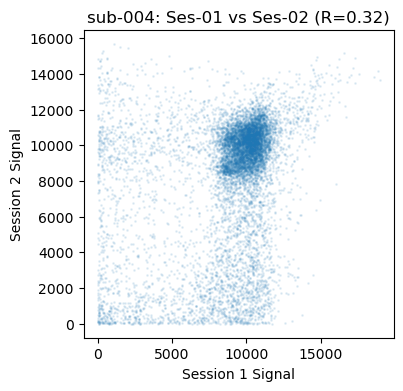

sub-008    | 0.4773          | POOR REGISTRATION


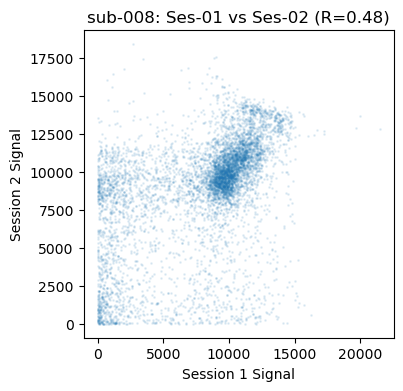

sub-079    | MISSING FILES   | CHECK PATHS


In [ ]:
import nibabel as nib
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Configuration
BASE_DIR = Path('/user_data/csimmon2/long_pt')
SUBJECTS = ['sub-004', 'sub-008'] # sub-079 likely still failing until fixed

def get_mean_vol(func_path):
    if not func_path.exists():
        return None
    img = nib.load(func_path)
    data = img.get_fdata()
    return np.mean(data, axis=3)

print(f"{'SUBJECT':<10} | {'CORRELATION (R)':<15} | {'STATUS'}")
print("-" * 55)

for sub in SUBJECTS:
    # SESSION 1: Uses standard file (Reference)
    f1 = BASE_DIR / sub / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / 'run-01' / '1stLevel.feat' / 'filtered_func_data_reg.nii.gz'
    
    # SESSION 2: Uses the NEW file registered to Session 1
    # <--- THIS IS THE CRITICAL CHANGE BELOW --->
    f2 = BASE_DIR / sub / 'ses-02' / 'derivatives' / 'fsl' / 'loc' / 'run-01' / '1stLevel.feat' / 'filtered_func_data_reg_ses01.nii.gz'

    if not f1.exists():
        print(f"{sub:<10} | {'MISSING SES-01':<15} | CHECK PATHS")
        continue
    if not f2.exists():
        print(f"{sub:<10} | {'MISSING SES-02':<15} | REGISTRATION SCRIPT DID NOT RUN")
        continue

    # Load and Flatten
    vol1 = get_mean_vol(f1)
    vol2 = get_mean_vol(f2)

    # Sanity Check: Shapes must match exactly
    if vol1.shape != vol2.shape:
        print(f"{sub:<10} | {'SHAPE MISMATCH':<15} | FAIL ({vol1.shape} vs {vol2.shape})")
        continue

    # Correlation
    mask = (vol1 > 0) & (vol2 > 0)
    
    if np.sum(mask) == 0:
        print(f"{sub:<10} | {'EMPTY MASK':<15} | FAIL")
        continue

    r = np.corrcoef(vol1[mask], vol2[mask])[0, 1]
    
    # We want R > 0.85 for good decoding
    status = "SUCCESS" if r > 0.85 else "POOR REGISTRATION"
    print(f"{sub:<10} | {r:.4f}          | {status}")

    # Plot if bad
    if r < 0.85:
        plt.figure(figsize=(4, 4))
        plt.scatter(vol1[mask][::100], vol2[mask][::100], alpha=0.1, s=1)
        plt.title(f"{sub}: Ses-01 vs Ses-02 (R={r:.2f})")
        plt.show()